<h1>Open Policing Project Data Analysis</h1>

<div class="alert alert-block alert-warning">
<p>I've been interested in analyzing policing and crime data for the last few years (see my analysis of San Francisco drug crime <a href="https://nbviewer.jupyter.org/github/mkogrady/data-analysis/blob/main/sf-crime/sf-crime-analysis.ipynb">here</a>). Recently, I stumbled upon the <a href="https://openpolicing.stanford.edu/">Stanford Open Policing Project</a>, a team at Stanford that collected and open-sourced a dataset of 60 million state police patrol stops from 20 different states. Over the last few nights I've spent some time replicating <a href="https://5harad.com/papers/100M-stops.pdf">their analysis</a>. I'll be adding new layers to this analysis over the next few weeks / months.</p>
    
<p>I went into this project with the belief that systemic racism exists and, after analyzing the data, I maintain that belief. I am not implying all police officers are racist, I am not implying that these results are 100% attributable to individual bias. I do, however, see the value in introducing policies to mitigate some of these biases. All I ask from anyone reading this is to lead with curiousity.</p>
</div>

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import astral
import astral.sun
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sqlalchemy import create_engine
import statsmodels.api as sm

import datetime
from dateutil import parser as date_parser
import json
import os
import random

<h2>Importing the data</h2>

<div class="alert alert-block alert-warning">
    <p>Here I'm just defining some functions to help me import the data by state. The first state I look at is MA as I've lived in Massachusetts and the dataset is a reasonable size.</p>
</div>

In [4]:
def append_df(df1, df2):
    if df1 is None:
        return df2
    return df1.append(df2, ignore_index=True)


def read_state_df(state):
    df = None
    for chunk in pd.read_csv('./data/clean/{}-clean.csv.gz'.format(state), compression='gzip', low_memory=False, chunksize=1000000):
        chunk_df = chunk.dropna(how='all')
        df = append_df(df, chunk_df)
    columns = []
    for column in df.columns:
        if len(df[~df[column].isnull()]) > 0:
            columns.append(column)
    return df[columns]

In [24]:
df = read_state_df('MA')

In [25]:
len(df)

3418298

<h2>Inspecting the dataset</h2>

<div class="alert alert-block alert-warning">
<p>I just wanted to get a feel for what's included in MA's dataset so I print out the first few rows. After I identify the columns of interest, I select only those to save memory and throw out any rows where both driver gender and race are missing.</p>
</div>

In [26]:
df.head(5)

,id,state,stop_date,location_raw,county_name,county_fips,fine_grained_location,driver_gender,driver_age_raw,driver_age,driver_race_raw,driver_race,violation,search_conducted,search_type_raw,search_type,contraband_found,stop_outcome,is_arrested,out_of_state
0,MA-2005-001,MA,2005-01-03,LEICESTER,Worcester County,25027.0,Route 9,M,NaN,NaN,White,White,NaN,False,NaN,NaN,False,Warning,False,False
1,MA-2005-002,MA,2005-01-03,LEICESTER,Worcester County,25027.0,Route 9,F,1964.0,41.0,White,White,NaN,False,NaN,NaN,False,Warning,False,False
2,MA-2005-003,MA,2005-01-03,LEICESTER,Worcester County,25027.0,Route 9,M,NaN,NaN,White,White,NaN,False,NaN,NaN,False,Warning,False,False
3,MA-2005-004,MA,2005-01-13,RAYNHAM,Bristol County,25005.0,Route 24,M,1955.0,50.0,White,White,NaN,False,NaN,NaN,False,Civil,False,False
4,MA-2005-005,MA,2005-01-16,TAUNTON,Bristol County,25005.0,Route 24,M,1958.0,47.0,White,White,Speeding,False,NaN,NaN,False,Civil,False,False


In [27]:
df = df[['county_name', 'county_fips', 'driver_gender', 'driver_age', 'driver_race', 'violation', 'search_conducted', 'search_type', 'contraband_found', 'stop_outcome', 'is_arrested', 'out_of_state', 'stop_date']]

df['violation'] = df.violation.fillna('N/A')
df['search_type'] = df.search_type.fillna('N/A')

df = df.dropna(subset=['driver_gender', 'driver_race'])

In [28]:
len(df)

3397188

<h2>Initial Working Dataset</h2>

<div class="alert alert-block alert-warning">
<p>I print out the data again after cleaning it to make sure it looks reasonable. Then I inspect the different kinds of violations, stop outcomes, and I count the number of stops by gender and race. As expected, the most common gender in the dataset is male and the most common race is white.</p>
</div>

In [29]:
df.head(3)

,county_name,county_fips,driver_gender,driver_age,driver_race,violation,search_conducted,search_type,contraband_found,stop_outcome,is_arrested,out_of_state,stop_date
0,Worcester County,25027.0,M,NaN,White,N/A,False,N/A,False,Warning,False,False,2005-01-03
1,Worcester County,25027.0,F,41.0,White,N/A,False,N/A,False,Warning,False,False,2005-01-03
2,Worcester County,25027.0,M,NaN,White,N/A,False,N/A,False,Warning,False,False,2005-01-03


In [30]:
df.violation.value_counts().head(10)

N/A                   1649492
Speeding              1519123
Seat belt              175710
Speeding,Seat belt      52863
Name: violation, dtype: int64

In [406]:
df.stop_outcome.value_counts()

Civil       1937733
Warning     1143054
Criminal     218012
Arrest        91921
Void           5562
Name: stop_outcome, dtype: int64

In [407]:
df.driver_gender.value_counts()

M    2360082
F    1037106
Name: driver_gender, dtype: int64

In [408]:
df.driver_race.value_counts()

White       2529408
Black        351713
Hispanic     338391
Asian        102300
Other         75376
Name: driver_race, dtype: int64

<h2>Stop Frequency</h2>

<div class="alert alert-block alert-warning">
<p>The first visualization below is stop frequency by race and age. The second is by race and year.</p>
</div>

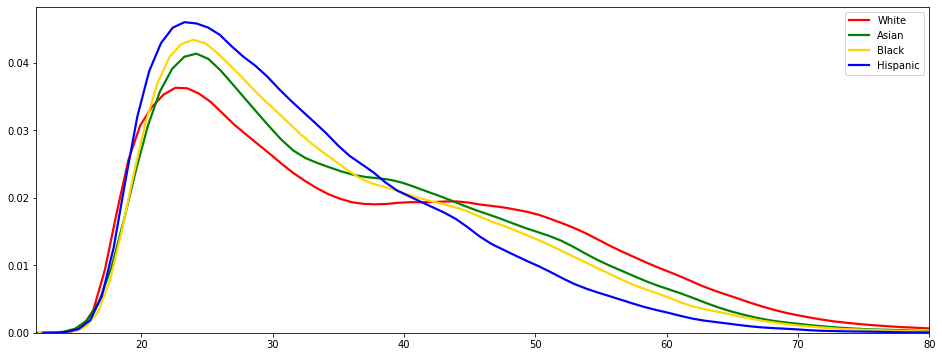

In [33]:
df = df[df.driver_race != 'Other']
df['stop_year'] = df.stop_date.apply(lambda d: d.split("-")[0])

df_race_age = df.dropna(subset=('driver_race', 'driver_age'))
driver_races = df_race_age.driver_race.unique()

fig, ax = plt.subplots(figsize=(16,6))
ax.set_xlim(12, 80)
for race in driver_races:
    s = df_race_age[df_race_age.driver_race == race].driver_age
    sns.kdeplot(data=s, shade=False, label=race, color=dict(White='r', Black='gold', Hispanic='b', Asian='g')[race], linewidth=2.2)
_ = ax.legend()

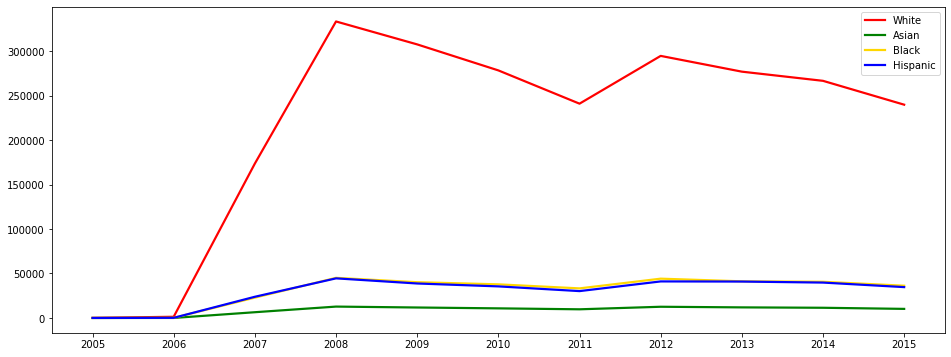

In [39]:
fig, ax = plt.subplots(figsize=(16,6))
for race in driver_races:
    s = df[df.driver_race == race].groupby('stop_year').count()['driver_age']
    sns.lineplot(data=s, label=race, color=dict(White='r', Black='gold', Hispanic='b', Asian='g')[race], linewidth=2.2)
_ = ax.legend()

<h2>Stops by County</h2>

<div class="alert alert-block alert-warning">
<p>Next I wanted to visualize the data on a map by county as I noticed the dataset included the county identifier (fips code). In order to do this, I needed access to the geometries of Massachusetts counties. Luckily, the government has a free dataset available so I downloaded it and transformed it into a GeoJSON feature collection. Then I merged the number of traffic stops in each county with the county geometries and used <a href="https://kepler.gl/">https://kepler.gl/</a> to display them on a map.</p>

<p>The most stops occur in/around Boston and Worcester which is more or less what I expected. Springfield also has a high number of stops.</p>
</div>

In [613]:
df.county_name.unique()

array([nan, 'Plymouth County', 'Berkshire County', 'Franklin County',
       'Suffolk County', 'Essex County', 'Bristol County',
       'Hampden County', 'Norfolk County', 'Worcester County',
       'Barnstable County', 'Middlesex County', 'Dukes County',
       'Hampshire County', 'Nantucket County'], dtype=object)

In [595]:
def get_county_features():
    with open('/Users/matthew/Desktop/acs/data/county_polygons.geojson') as f:
        polygons = json.load(f)
    return polygons


def apply_stops_to_features(counties, df):
    feature_collection = {'type': 'FeatureCollection', 'features': []}
    stops_by_fips = df.groupby('fips').count()[['id']].to_dict('index')
    for feature in counties['features']:
        stops = stops_by_fips.get(feature['properties']['fips'], {}).get('id')
        if stops is not None:
            feature['properties']['num_stops'] = stops
            feature_collection['features'].append(feature)
    return feature_collection


county_features = apply_stops_to_features(get_county_features(), df)
with open('county_features.geojson', 'w') as f:
    json.dump(county_features, f)

<img src="ma-traffic-stops.png" />

<h2>Stop Rate Per Capita</h2>

<div class="alert alert-block alert-warning">
<p>Next I wanted to calculate stop rates for each race but I knew these rates would only be meaningful when compared against the demographics of Massachusetts. I went to <a href="https://data.census.gov/cedsci/">https://data.census.gov/cedsci/</a> to download demographic information for each county in Massachusetts. I downloaded the data from the ACS website and uploaded it into a local PostgreSQL database, partioning it by year. Below I define some functions for reading this data in and using it to calculate stop rates.</p>
</div>

In [42]:
#convert fips column to a string for ease of use
df['fips'] = df.county_fips.apply(lambda x: None if np.isnan(x) else str(int(x)))

In [5]:
CENSUS_CODE_HISPANIC_POP = 'B03002_012E'
CENSUS_CODE_BLACK_POP = 'B03002_004E'
CENSUS_CODE_ASIAN_POP = 'B03002_006E'
CENSUS_CODE_WHITE_POP = 'B03002_003E'

ALL_CENSUS_CODES = (CENSUS_CODE_BLACK_POP,
                    CENSUS_CODE_ASIAN_POP,
                    CENSUS_CODE_HISPANIC_POP,
                    CENSUS_CODE_WHITE_POP)

ENGINE = None


def get_engine():
    global ENGINE
    if ENGINE is None:
        ENGINE = create_engine('postgresql://postgres@localhost/census')
    return ENGINE


def read_county_population_data(eng, year, fips='*'):
    select = ",".join(['c.geoid AS fips', 'pop.name'] + list(ALL_CENSUS_CODES))
    qry = """SELECT
{select}
FROM
  county c
LEFT JOIN
  county_b03_{year} pop
  ON c.affgeoid = pop.geoid
""".format(select=select, year=year)
    if fips != '*':
        where = " WHERE c.geoid IN({})".format(", ".join(["'{}'".format(f) for f in fips]))
        qry += where
    df = pd.read_sql(qry, eng, index_col='fips')
    return df
    
    
def read_population_data(eng, fips='*'):
    data = {}
    for year in range(2011, 2016): # these are the only years I downloaded the demographics data for
        df_population = read_county_population_data(eng, year, fips=fips)
        data[str(year)] = df_population
    return data


def get_population_data_for_df(df):
    engine = get_engine()
    fips = df[~df.fips.isnull()].fips.unique().tolist()
    pop_data_by_year = read_population_data(engine, fips=fips)
    return pop_data_by_year

    
def compute_stop_rates(df, pop_data):
    
    def compute_stop_rate(driver_race, census_code):
        # compute stop rate using the county population
        pop = pop_data.get(census_code.lower(), 0)
        if pop <= 20:
            return None
        return len(df[df.driver_race == driver_race]) / pop

    return dict(white_stop_rate=compute_stop_rate('White', CENSUS_CODE_WHITE_POP), 
                asian_stop_rate=compute_stop_rate('Asian', CENSUS_CODE_ASIAN_POP), 
                hispanic_stop_rate=compute_stop_rate('Hispanic', CENSUS_CODE_HISPANIC_POP), 
                black_stop_rate=compute_stop_rate('Black', CENSUS_CODE_BLACK_POP))

<div class="alert alert-block alert-warning">
<p>Below I read in the demographic data and then group by dataframe by county fips and year so that I can compare the number of stops to the individual county's population for that year.</p>
</div>

In [6]:

def stop_rates_per_capita(df):
    population_data = get_population_data_for_df(df)

    all_stop_rates = []
    for group, df_group in df.groupby(['fips', 'stop_year']):
        fips = group[0]
        year = group[1]
        if year not in population_data:
            continue
        # filter population data by this year and county fips code
        df_population = population_data[year]
        df_pop_fips = df_population[df_population.index == fips]
        fips_pop_data = df_pop_fips.to_dict('records')[0] if len(df_pop_fips) == 1 else {}
        # compute stop rates against this county's population
        stop_rates = compute_stop_rates(df_group, fips_pop_data)
        stop_rates['fips'] = fips
        stop_rates['year'] = year
        all_stop_rates.append(stop_rates)

    return pd.DataFrame(all_stop_rates)


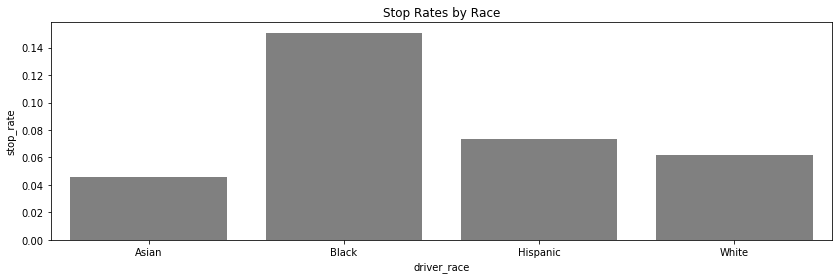

In [46]:
df_stop_rates = stop_rates_per_capita(df)
avg_stop_rates = df_stop_rates[['asian_stop_rate', 'black_stop_rate', 'hispanic_stop_rate', 'white_stop_rate']].mean().reset_index()
avg_stop_rates['driver_race'] = avg_stop_rates['index'].apply(lambda x: x.split('_')[0].capitalize())
avg_stop_rates['stop_rate'] = avg_stop_rates[0]

fig, axes = plt.subplots(figsize=(14, 4))
_ = sns.barplot(data=avg_stop_rates, 
                x='driver_race', 
                y='stop_rate', 
                color='gray', 
                ax=axes).set_title('Stop Rates by Race')

<div class="alert alert-block alert-warning">
<p>I think it's pretty clear from the graph above that black and hispanic drivers are stopped more frequently than white drivers relative to their share of the city's population. Let's compare the stop rate of white drivers with black and hispanic drivers directly:</p>
</div>

In [646]:
black_stop_rate = avg_stop_rates[avg_stop_rates.driver_race == 'Black'].iloc[0]['stop_rate']
hispanic_stop_rate = avg_stop_rates[avg_stop_rates.driver_race == 'Hispanic'].iloc[0]['stop_rate']
white_stop_rate = avg_stop_rates[avg_stop_rates.driver_race == 'White'].iloc[0]['stop_rate']

compare_stop_rate = lambda r: round(r / white_stop_rate, 1)

compare_stop_rate(black_stop_rate), compare_stop_rate(hispanic_stop_rate)

(2.4, 1.2)

<div class="alert alert-block alert-warning">
<p>Black drivers are stopped at a rate <b>2.4 times higher</b> than white drivers, Hispanic drivers are stopped at a rate <b>1.2 times higher</b> than white drivers.</p>
</div>

<h2>Stop Outcomes</h2>

<div class="alert alert-block alert-warning">
<p>Now that I've looked at stop rates, I want to look at the rates of different stop outcomes. These rates are much easier to analyze because our baseline population is the stopped population rather than the external county population. Below I'll define a function for computing stop outcomes for Massachusetts and then visualize these different outcomes per gender and race.</p>
</div>

In [651]:

def ma_stop_outcomes(df):
    warnings = len(df[df.stop_outcome == 'Warning'])
    civil_citations = len(df[df.stop_outcome == 'Civil'])
    criminal_citations = len(df[df.stop_outcome == 'Criminal'])
    citations = civil_citations + criminal_citations
    arrests = len(df[df.stop_outcome == 'Arrest'])
    citations_per_warning = citations / warnings
    civil_citations_per_warning = civil_citations / warnings
    criminal_citations_per_warning = criminal_citations / warnings
    arrest_rate = arrests / len(df)
    warning_rate = warnings / len(df)
    return pd.Series(data=dict(
        warning_rate=warning_rate,
        citations_per_warning=citations_per_warning,
        criminal_citations_per_warning=criminal_citations_per_warning,
        civil_citations_per_warning=civil_citations_per_warning, 
        arrest_rate=arrest_rate))
    

In [652]:
df.groupby('driver_gender').apply(ma_stop_outcomes)

,warning_rate,citations_per_warning,criminal_citations_per_warning,civil_citations_per_warning,arrest_rate
driver_gender,,,,,
F,0.375891,1.61512,0.142252,1.472868,0.015391
M,0.320670,2.01058,0.217461,1.793119,0.032591


In [653]:
df.groupby('driver_race').apply(ma_stop_outcomes)

,warning_rate,citations_per_warning,criminal_citations_per_warning,civil_citations_per_warning,arrest_rate
driver_race,,,,,
Asian,0.286380,2.421813,0.152791,2.269022,0.018554
Black,0.319141,2.018224,0.348854,1.669370,0.034769
Hispanic,0.278310,2.371985,0.589770,1.782215,0.059367
White,0.350707,1.782059,0.130405,1.651654,0.022350


In [655]:
df.groupby(['driver_race', 'driver_gender']).apply(ma_stop_outcomes)[['warning_rate', 'citations_per_warning', 'arrest_rate']]

warning_rate  citations_per_warning  arrest_rate
driver_race driver_gender                                                  
Asian       F                  0.315076               2.136168     0.010577
            M                  0.274388               2.559044     0.021888
Black       F                  0.342888               1.867778     0.014742
            M                  0.310205               2.080851     0.042322
Hispanic    F                  0.315793               2.085149     0.023920
            M                  0.266987               2.474684     0.070082
White       F                  0.388336               1.532833     0.014852
            M                  0.332744               1.921354     0.025940

<div class="alert alert-block alert-warning">
<p>You'll notice white women drivers are the most likely to receive warnings. The arrest rate is highest for hispanic drivers followed by black drivers. Asian drivers are the most likely to receive a citation but the least likely to be arrested.</p>
</div>

<div class="alert alert-block alert-warning">
<p>Now let's visualize these results. I also wanted to visualize the warning and arrest rates for the most common violations in the dataset (Speeding and Seatbelt). You'll notice white drivers are most likely to be let off with a warning. Hispanic and black drivers are the most likely to be arrested when the initial violation is Speeding or Seatbelt.</p>
</div>

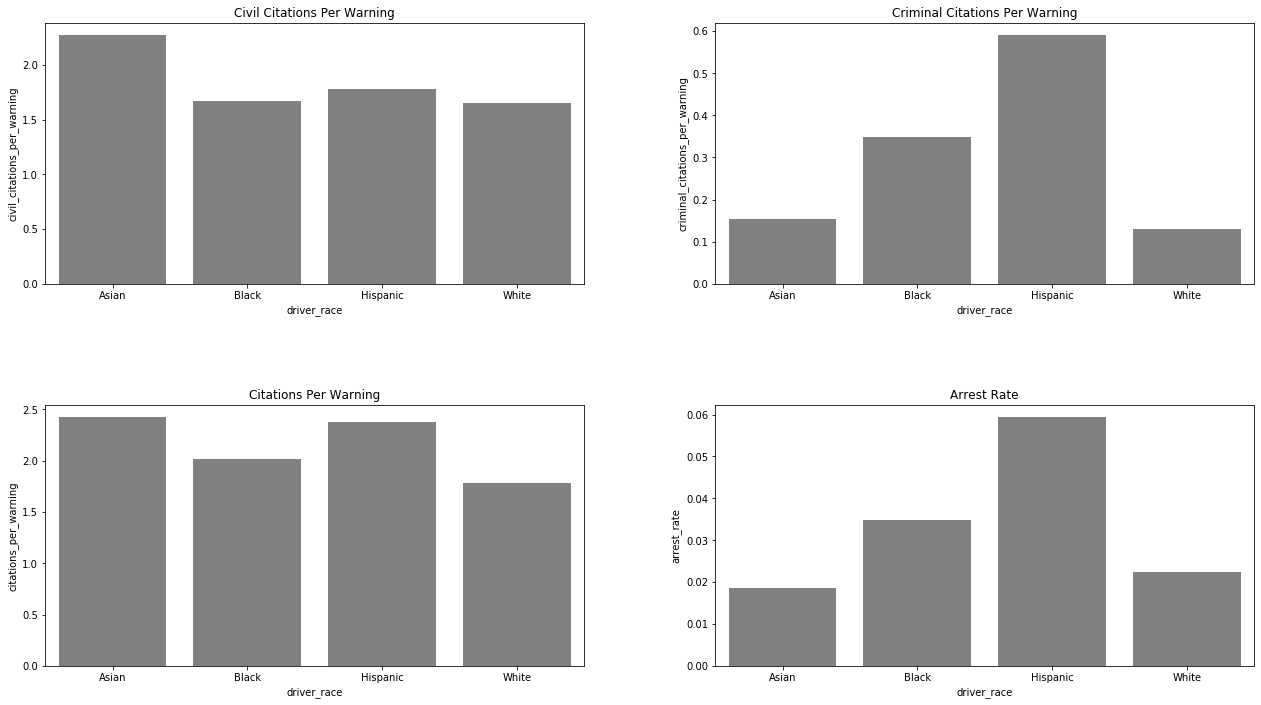

In [447]:
outcomes_by_race = df.groupby('driver_race').apply(ma_stop_outcomes).reset_index()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
fig.tight_layout(pad=10.0)

sns.barplot(data=outcomes_by_race, 
            x='driver_race', 
            y='civil_citations_per_warning', 
            color='gray', 
            ax=axes[0, 0]).set_title('Civil Citations Per Warning')
sns.barplot(data=outcomes_by_race, 
            x='driver_race', 
            y='criminal_citations_per_warning', 
            color='gray', 
            ax=axes[0, 1]).set_title('Criminal Citations Per Warning')
sns.barplot(data=outcomes_by_race, 
            x='driver_race', 
            y='citations_per_warning', 
            color='gray', 
            ax=axes[1, 0]).set_title('Citations Per Warning')
_ = sns.barplot(data=outcomes_by_race, 
                x='driver_race', 
                y='arrest_rate', 
                color='gray', 
                ax=axes[1, 1]).set_title('Arrest Rate')

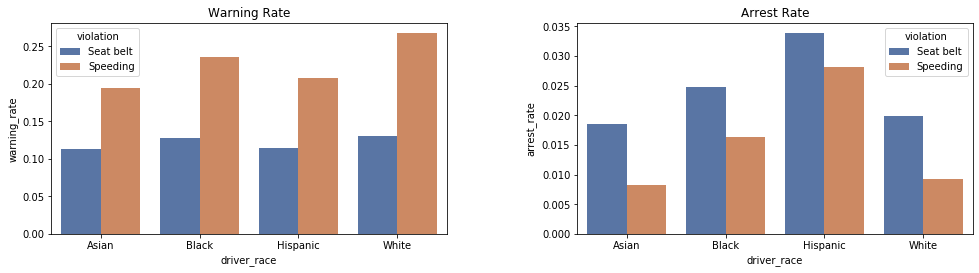

In [448]:
violation_outcomes = df[df.violation.isin(['Seat belt', 'Speeding'])].\
    groupby(['violation', 'driver_race']).apply(ma_stop_outcomes).reset_index()


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
fig.tight_layout(pad=10.0)

sns.barplot(data=violation_outcomes, 
            x='driver_race', 
            y='warning_rate', 
            hue='violation',
            ax=axes[0]).set_title('Warning Rate')
_ = sns.barplot(data=violation_outcomes, 
            x='driver_race', 
            y='arrest_rate',
            hue='violation',
            ax=axes[1]).set_title('Arrest Rate')

<h2>Outcome Test</h2>

<div class="alert alert-block alert-warning">
<p>Now that we've looked at stop rates and stop outcomes, we can do something a little more interesting. Now we will analyze the searches. We know a search of a driver was "successful" when it uncovers contraband. We can use our "search_conducted" and "contraband_found" columns to analyze the search and "success" rates among different driver races. Below I define a function for computing search and hit rates and then I use it to compute these rates by gender, age, and race. You'll notice the search rate and hit rate trends downward as driver age increases.</p>
</div>

In [220]:
def search_and_hit_rates(df):
    search_conducted = df.search_conducted
    contraband_found = df.contraband_found
    stops = len(df)
    searches = df.search_conducted.sum()
    hits = df.contraband_found.sum()
    search_rate = searches / stops if stops >= 50 else None
    hit_rate = hits / searches if searches >= 5 else None
        
    return pd.Series(data=dict(stops=stops, 
                               searches=searches, 
                               hits=hits, 
                               search_rate=search_rate, 
                               hit_rate=hit_rate))

In [450]:
df.groupby('driver_gender').apply(search_and_hit_rates)

,stops,searches,hits,search_rate,hit_rate
driver_gender,,,,,
F,1022606.0,9980.0,4531.0,0.009759,0.454008
M,2299206.0,45643.0,23236.0,0.019852,0.509081


In [451]:
age_groups = pd.cut(df.driver_age, np.arange(15, 85, 10))
df.groupby(age_groups).apply(search_and_hit_rates)

,stops,searches,hits,search_rate,hit_rate
driver_age,,,,,
"(15, 25]",845003.0,22371.0,12864.0,0.026474,0.575030
"(25, 35]",879312.0,17635.0,8293.0,0.020055,0.470258
"(35, 45]",623331.0,8583.0,3718.0,0.013770,0.433182
"(45, 55]",498883.0,4726.0,1993.0,0.009473,0.421710
"(55, 65]",246028.0,1380.0,536.0,0.005609,0.388406
"(65, 75]",69810.0,245.0,63.0,0.003510,0.257143


<div class="alert alert-block alert-warning">
<p>Here I compute the search rate and hit rate by driver race. Notice that black and hispanic drivers are searched at a higher rate than white drivers despite contraband being found at the highest rate among white drivers.</p>
</div>

In [452]:
df.groupby('driver_race').apply(search_and_hit_rates)

,stops,searches,hits,search_rate,hit_rate
driver_race,,,,,
Asian,102300.0,1078.0,357.0,0.010538,0.331169
Black,351713.0,8561.0,4170.0,0.024341,0.487093
Hispanic,338391.0,11139.0,5009.0,0.032918,0.449681
White,2529408.0,34845.0,18231.0,0.013776,0.523203


<div class="alert alert-block alert-warning">
<p>Next I account for location to ensure one county isn't throwing off the results for the overall dataset. You can see below that Black and Hispanic drivers are searched at significantly higher rates than white drivers despite having lower hit rates even when accounting for location.</p>
</div>

In [206]:
def generate_comparison_scatter(df, ax, state, race, field, color):
    race_location_agg = df.groupby(['county_fips','driver_race']).apply(search_and_hit_rates).reset_index().dropna()    
    race_location_agg = race_location_agg.pivot(index='county_fips', columns='driver_race', values=field)
    ax = sns.scatterplot(data=race_location_agg, x='White', y=race, label=race, color=color, ax=ax)
    return ax


def format_scatter_chart(ax, state, field):
    ax.set_xlabel('{} - White'.format(field))
    ax.set_ylabel('{} - Non-White'.format(field, race))
    ax.set_title('{} By County - {}'.format(field, state))
    lim = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.set_xlim(0, lim)
    ax.set_ylim(0, lim)
    diag_line, = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
    ax.legend()
    return ax


def generate_comparison_scatters(df, state):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    generate_comparison_scatter(df, axes[0], state, 'Black', 'search_rate', 'red')
    generate_comparison_scatter(df, axes[0], state, 'Hispanic', 'search_rate', 'orange')
    generate_comparison_scatter(df, axes[0], state, 'Asian', 'search_rate', 'green')
    format_scatter_chart(axes[0], state, 'Search Rate')
    
    generate_comparison_scatter(df, axes[1], state, 'Black', 'hit_rate', 'red')
    generate_comparison_scatter(df, axes[1], state, 'Hispanic', 'hit_rate', 'orange')
    generate_comparison_scatter(df, axes[1], state, 'Asian', 'hit_rate', 'green')
    format_scatter_chart(axes[1], state, 'Hit Rate')

    return fig

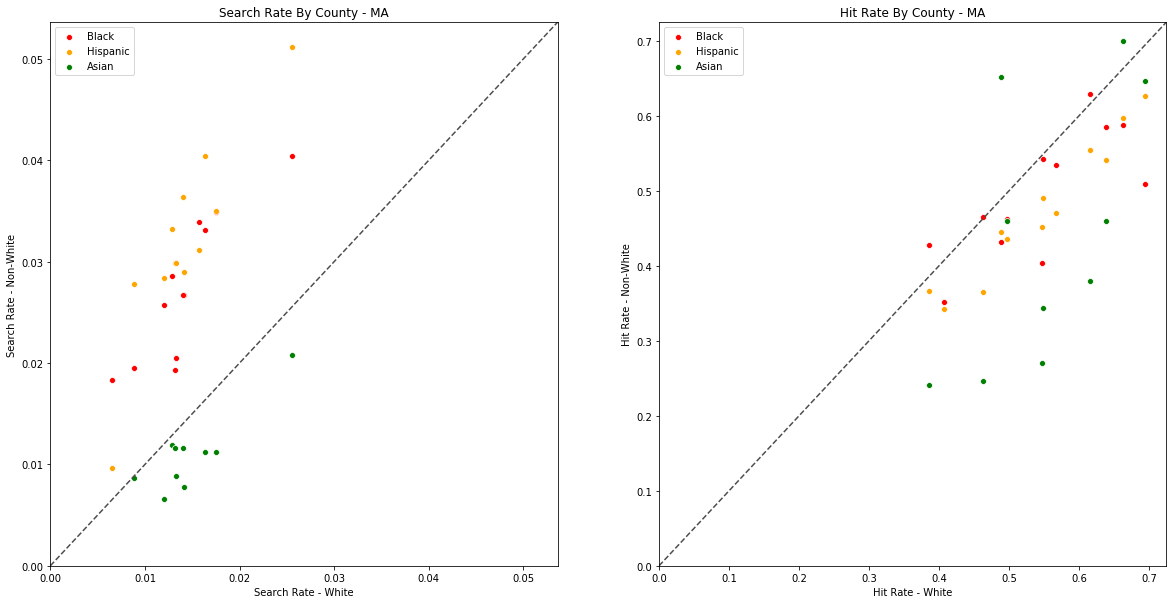

In [454]:
_ = generate_comparison_scatters(df, 'MA')

In [465]:
def generate_county_search_stats_scatter(df, state):
    race_location_agg = df.groupby(['county_fips','driver_race']).apply(search_and_hit_rates)

    colors = ['green','red', 'gold','blue']
    fig, ax = plt.subplots(figsize=(20, 10))
    for c, frame in race_location_agg.groupby(level='driver_race'):
        sns.scatterplot(x=frame['hit_rate'], y=frame['search_rate'], s=150, label=c, color=colors.pop(), ax=ax)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4, fancybox=True)
    ax.set_xlabel('Hit Rate')
    ax.set_ylabel('Search Rate')
    ax.set_title("Search Stats By County and Race - {}".format(state))
    return fig

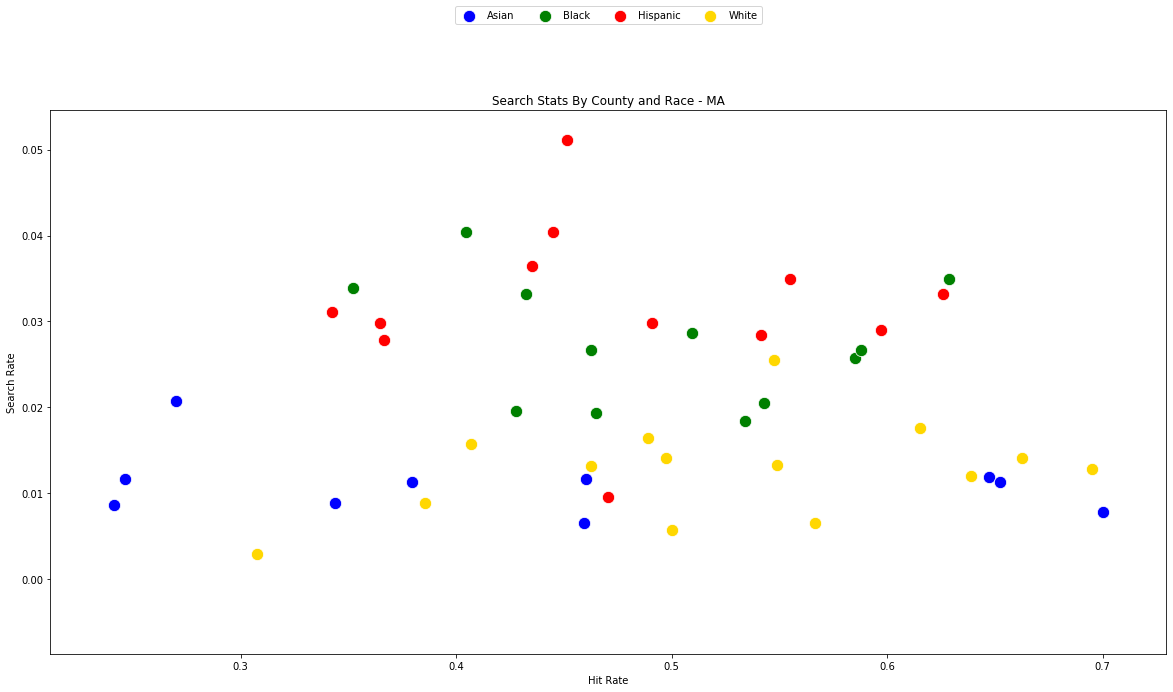

In [460]:
_ = generate_county_search_stats_scatter(df, 'MA')

<h2>Colorado</h2>

<div class="alert alert-block alert-warning">
<p>Colorado is a state I enjoy visiting that also has a reasonably sized dataset. I read in the data, clean it, and compute stop rates and perform the outcome test.</p>
</div>

In [4]:
df_co = read_state_df('CO')

In [5]:
df_co.head(5)

,id,state,stop_date,stop_time,location_raw,county_name,county_fips,fine_grained_location,police_department,driver_gender,...,search_conducted,search_type_raw,search_type,contraband_found,stop_outcome,is_arrested,officer_id,officer_gender,vehicle_type,out_of_state
0,CO-2010-000001,CO,2010-01-01,00:00,10.0,Arapahoe County,8005.0,289,Golden,F,...,False,NaN,NaN,False,Verbal Warning,False,1024976.0,M,NA NA 0,False
1,CO-2010-000002,CO,2010-01-01,00:01,4.0,El Paso County,8041.0,3,Colorado Springs,F,...,False,NaN,NaN,False,Verbal Warning,False,1069803.0,NaN,NA NA 0,False
2,CO-2010-000003,CO,2010-01-01,00:01,24.0,Garfield County,8045.0,3,Glenwood Springs,M,...,False,NaN,NaN,False,Verbal Warning,False,1198321.0,M,NA NA 0,False
3,CO-2010-000004,CO,2010-01-01,00:02,19.0,Yuma County,8125.0,NaN,Sterling,M,...,False,NaN,NaN,False,Citation,False,1167059.0,NaN,Ford F-250 2003,False
4,CO-2010-000005,CO,2010-01-01,00:02,11.0,Jefferson County,8059.0,NaN,6A,F,...,False,NaN,NaN,False,Written Warning,False,1300790.0,NaN,Oldsmobile Intrigue 1999,False


In [11]:
df_co = df_co[['county_name', 'county_fips', 'driver_gender', 'driver_age', 'driver_race', 'violation', 'search_conducted', 'search_type', 'contraband_found', 'stop_outcome', 'is_arrested', 'out_of_state', 'stop_date', 'stop_time', 'officer_id', 'officer_gender']]

df_co['violation'] = df_co.violation.fillna('N/A')
df_co['search_type'] = df_co.search_type.fillna('N/A')


df_co = df_co.dropna(subset=['driver_gender', 'driver_race'])

In [163]:
df_co = df_co[df_co.driver_race != 'Other']
df_co = df_co[~df_co.stop_date.isnull()]
df_co['stop_year'] = df_co.stop_date.apply(lambda d: d.split("-")[0])
df_co = df_co[df_co.stop_year < '2016']
#convert fips column to a string for ease of use
df_co['fips'] = df_co.county_fips.apply(lambda x: None if np.isnan(x) else str(int(x)).zfill(5))
df_co = df_co[df_co.out_of_state == False]

df_co.head(3)

,county_name,county_fips,driver_gender,driver_age,driver_race,violation,search_conducted,search_type,contraband_found,stop_outcome,is_arrested,out_of_state,stop_date,stop_time,officer_id,officer_gender,stop_year,fips
0,Arapahoe County,8005.0,F,19.0,White,Lights,False,N/A,False,Verbal Warning,False,False,2010-01-01,00:00,1024976.0,M,2010,08005
1,El Paso County,8041.0,F,16.0,White,Speeding,False,N/A,False,Verbal Warning,False,False,2010-01-01,00:01,1069803.0,NaN,2010,08041
2,Garfield County,8045.0,M,60.0,White,Safe movement,False,N/A,False,Verbal Warning,False,False,2010-01-01,00:01,1198321.0,M,2010,08045


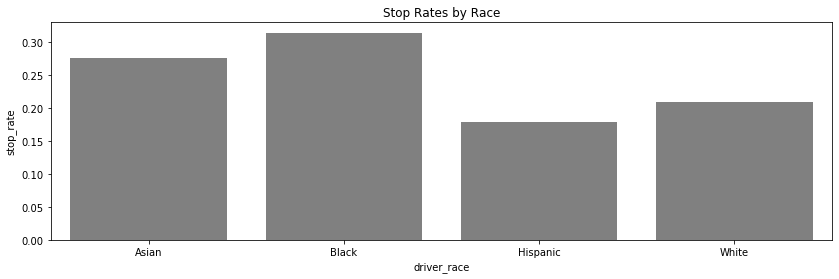

In [203]:
df_co_stop_rates = stop_rates_per_capita(df_co)

co_avg_stop_rates = df_co_stop_rates[['asian_stop_rate', 'black_stop_rate', 'hispanic_stop_rate', 'white_stop_rate']].mean().reset_index()
co_avg_stop_rates['driver_race'] = co_avg_stop_rates['index'].apply(lambda x: x.split('_')[0].capitalize())
co_avg_stop_rates['stop_rate'] = co_avg_stop_rates[0]

fig, axes = plt.subplots(figsize=(14, 4))
_ = sns.barplot(data=co_avg_stop_rates, 
                x='driver_race', 
                y='stop_rate', 
                color='gray', 
                ax=axes).set_title('Stop Rates by Race')

In [204]:
black_stop_rate = co_avg_stop_rates[co_avg_stop_rates.driver_race == 'Black'].iloc[0]['stop_rate']
white_stop_rate = co_avg_stop_rates[co_avg_stop_rates.driver_race == 'White'].iloc[0]['stop_rate']

round(black_stop_rate / white_stop_rate, 1)

1.5

<div class="alert alert-block alert-warning">
<p>Black drivers are stopped at a rate 1.5 times higher than white drivers.</p>
</div>

<h2>Colorado Outcome Test</h2>

<div class="alert alert-block alert-warning">
<p>Perhaps a little less pronounced than others but still indicative of bias.</p>
</div>

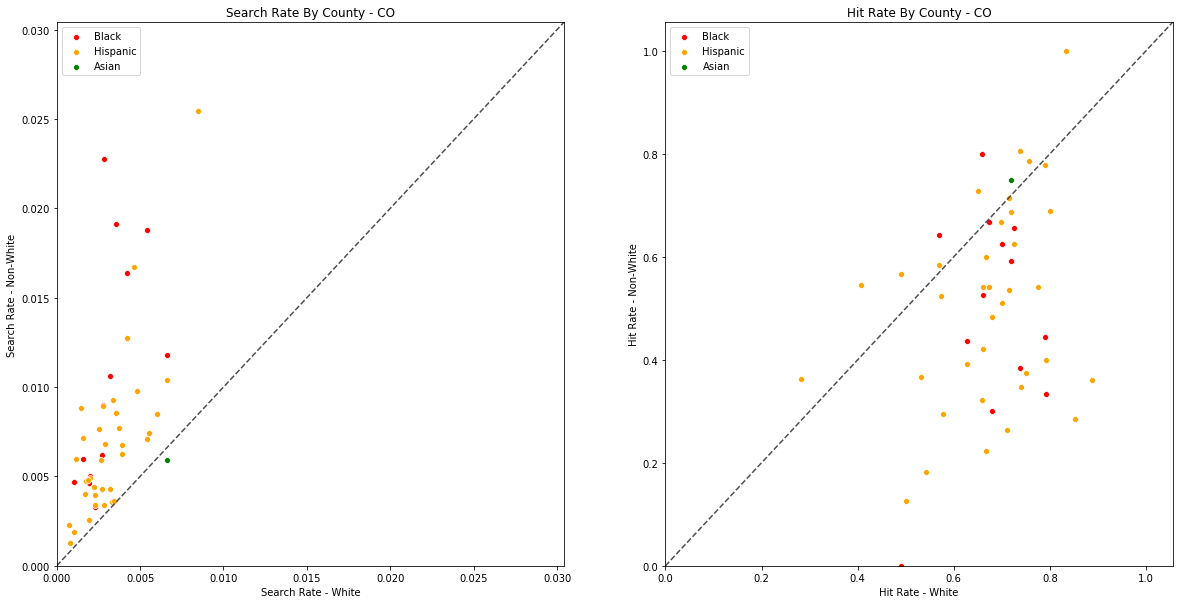

In [221]:
_ = generate_comparison_scatters(df_co, 'CO')

<h2>New Jersey</h2>

<div class="alert alert-block alert-warning">
<p>Next, I read in New Jersey's data. I was born in NJ, the dataset is a reasonable size, and it includes some columns that aren't available in others. We will use one of these new columns, stop time, to attempt a new test. First, we'll clean up the data and compute some stop rates.</p>
</div>

In [7]:
df_nj = read_state_df('NJ')

In [8]:
df_nj.head(5)

,id,state,stop_date,stop_time,location_raw,county_name,county_fips,fine_grained_location,police_department,driver_gender,driver_race_raw,driver_race,violation_raw,violation,stop_outcome,officer_id,out_of_state,vehicle_make,vehicle_model,vehicle_color
0,NJ-2009-000001,NJ,2009-01-01,00:00,Bordentown Twp,Burlington County,34005.0,GROVEVILLE/ 130 SB,C060,M,W - WHITE,White,39:4-99 EXCEED SPEED LIMITATIONS,Speeding,Warning,6578.0,True,Saturn,NaN,GRN
1,NJ-2009-000002,NJ,2009-01-01,00:01,Lacey Twp,Ocean County,34029.0,@GSP NB MP 76.5 LACEY TWP-OCE E030,E030,M,OA - OTHER ASIAN,Asian,NaN,NaN,NaN,6364.0,True,Toyota,NaN,BLK
2,NJ-2009-000003,NJ,2009-01-01,00:06,Pittsgrove Twp,Salem County,34033.0,56 W MP 7,A040,M,H - HISPANIC,Hispanic,39:3-40 DRIVE WITHOUT LICENSE|39:4-98 RATES OF...,"License,Speeding",Summons,6488.0,False,NaN,NaN,SIL
3,NJ-2009-000004,NJ,2009-01-01,00:08,Fairfield Twp,Cumberland County,34011.0,@I-80 EB MP 48.5 FAIRFIELD TWP-ESS B200,B060,F,B - BLACK,Black,NaN,NaN,NaN,6440.0,True,Jeep,NaN,BLK
4,NJ-2009-000005,NJ,2009-01-01,00:09,Bass River Twp,Burlington County,34005.0,@GSP NB MP 52.2 BASS RIVER TWP-BUR E030,E030,M,W - WHITE,White,39:4-99 EXCEED SPEED LIMITATIONS,Speeding,Warning,4003.0,False,Cadillac,NaN,WHI


In [9]:
df_nj = df_nj[['county_name', 'county_fips', 'driver_gender', 'driver_race', 'violation', 'stop_outcome', 'out_of_state', 'stop_date', 'stop_time', 'officer_id', 'police_department', 'vehicle_make', 'vehicle_color']]

df_nj['violation'] = df_nj.violation.fillna('N/A')
df_nj['stop_outcome'] = df_nj.stop_outcome.fillna('N/A')


df_nj = df_nj.dropna(subset=['driver_gender', 'driver_race', 'stop_date'])

In [10]:
df_nj.head(3)

,county_name,county_fips,driver_gender,driver_race,violation,stop_outcome,out_of_state,stop_date,stop_time,officer_id,police_department,vehicle_make,vehicle_color
0,Burlington County,34005.0,M,White,Speeding,Warning,True,2009-01-01,00:00,6578.0,C060,Saturn,GRN
1,Ocean County,34029.0,M,Asian,N/A,N/A,True,2009-01-01,00:01,6364.0,E030,Toyota,BLK
2,Salem County,34033.0,M,Hispanic,"License,Speeding",Summons,False,2009-01-01,00:06,6488.0,A040,NaN,SIL


In [11]:
df_nj['stop_year'] = df_nj.stop_date.apply(lambda d: d.split("-")[0])
df_nj['fips'] = df_nj.county_fips.apply(lambda x: None if np.isnan(x) else str(int(x)).zfill(5))

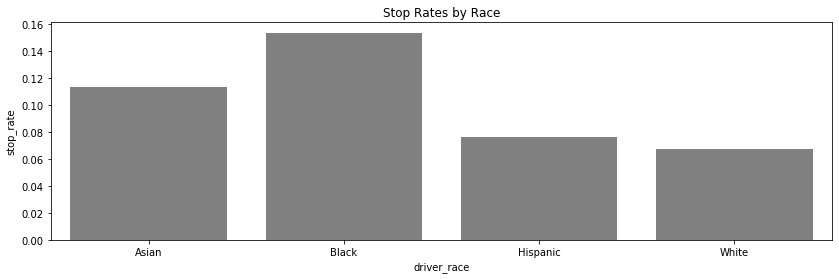

In [12]:
df_nj_stop_rates = stop_rates_per_capita(df_nj)

nj_avg_stop_rates = df_nj_stop_rates[['asian_stop_rate', 'black_stop_rate', 'hispanic_stop_rate', 'white_stop_rate']].mean().reset_index()
nj_avg_stop_rates['driver_race'] = nj_avg_stop_rates['index'].apply(lambda x: x.split('_')[0].capitalize())
nj_avg_stop_rates['stop_rate'] = nj_avg_stop_rates[0]

fig, axes = plt.subplots(figsize=(14, 4))
_ = sns.barplot(data=nj_avg_stop_rates, 
                x='driver_race', 
                y='stop_rate', 
                color='gray', 
                ax=axes).set_title('Stop Rates by Race')

In [13]:
black_stop_rate = nj_avg_stop_rates[nj_avg_stop_rates.driver_race == 'Black'].iloc[0]['stop_rate']
white_stop_rate = nj_avg_stop_rates[nj_avg_stop_rates.driver_race == 'White'].iloc[0]['stop_rate']

round(black_stop_rate / white_stop_rate, 1)

2.3

<div class="alert alert-block alert-warning">
<p>Black drivers are stopped at a rate <b>2.3</b> times higher than white drivers.</p>
</div>

<h2>Veil of Darkness Test</h2>

<div class="alert alert-block alert-warning">
<p>This is one of the more interesting tests. See the paragraph below for the full explanation of the test. The TLDR version is that we will try comparing the proportion of black drivers during a time range that is dark in the winter and light in the summer. The theory is, officers engaged in racial profiling will be less likely to identify someone's race in a car after dark so the proportion of black drivers will be smaller when it's dark.</p>
</div>


<p><i>An alternative approach to assessing bias in stop decisions was proposed by Grogger and Ridgeway in 2006. This approach, known as the Veil of Darkness test, relies on the hypothesis that officers who are engaged in racial profiling are less likely to be able to identify a driver’s race after dark than during daylight. Under this hypothesis, if stops made after dark had smaller proportion of black drivers stopped than stops made during daylight, this would be evidence of the presence of racial profiling.

The naive approach is just to compare whether daytime stops or nighttime stops have higher proportion of black drivers. This, however, is problematic. More black drivers being stopped at night could be the case for a multitude of reasons: different deployment and enforcement patterns, different driving patterns, etc. All of these things correlate with clock time and would be confounding our results. So let’s find a way to adjust for clock time.

To adjust for clock time, we want to compare times that were light at some point during the year (i.e., occurred before dusk) but were dark at other points during the year (i.e., occurred after dusk). This is called the “inter-twilight period”: the range from the earliest time dusk occurs in the year to the latest time dusk occurs in the year.</i></p>

<div class="alert alert-block alert-warning">
<p>To start, I just run a very dumb (see explanation above) check to test the compute portion function which will provide the proportion of black drivers in a dataset. This test says the proportion of black drivers being stopped is larger at night, let's see if that changes when we improve the test.</p>
</div>

In [62]:
def is_dark(stop_time):
    # we'll just use this as the initial dumb window for daylight
    return stop_time > '19:00' or stop_time < '06:30'


def compute_portion(df):
    stops = len(df[df.driver_race == 'Black'])
    return pd.Series(data=dict(prop_black=stops/len(df)))


df_nj['is_dark'] = df_nj.stop_time.apply(is_dark)
df_nj.groupby('is_dark').apply(compute_portion)

,prop_black
is_dark,
False,0.174979
True,0.227737


<div class="alert alert-block alert-warning">
<p>In order to improve the test, we must calculate the sunset and dusk times for the dataset. I don't have the exact location for each traffic stop, but I do have the county. I'll calculate the centroid of each county and use that as my location. I read in the county centroid dataset below and merge it into my dataframe.</p>
</div>

In [ ]:
def read_county_centroids(eng, fips='*'):
    where = '' if fips == '*' else "WHERE c.geoid IN({})".format(", ".join(["'{}'".format(f) for f in fips]))
    # I could alter the county table to include the centroid but I'm lazy 
    qry = """WITH county_centroids AS (
  SELECT 
    c.geoid AS fips,
    ST_Transform(ST_Centroid(c.geom), 4326) AS centroid
  FROM
    county c
  {where}
)
SELECT
  fips,
  ST_Y(centroid) AS lat,
  ST_X(centroid) AS lng
FROM county_centroids;
""".format(where=where)
    df = pd.read_sql(qry, eng, index_col='fips')
    return df


df_county_centroids = read_county_centroids(get_engine(), df_nj.fips.unique().tolist())

In [ ]:
df_nj = df_nj.merge(df_county_centroids, on='fips')

<div class="alert alert-block alert-warning">
<p>After I have coordinates attached to each traffic stop, I'll compute the sunset and dusk times for the dataset. Because I'm using the county centroid, I don't need to compute sunset and dusk for every row in the data. I can just compute it for each latitude,longitude + date pair and save my computer some fan spinning.</p>
</div>

In [ ]:
def compute_sun(row):
    stop_date = date_parser.parse(row['stop_date']).date()
    city = astral.LocationInfo("New York", "US", "America/New_York", latitude=row['lat'], longitude=row['lng'])
    sun = astral.sun.sun(city.observer, date=stop_date, tzinfo=city.timezone)
    sunset = sun['sunset']
    dusk = sun['dusk']
    return dict(sunset=sunset.time().strftime("%H:%M"),
                dusk=dusk.time().strftime("%H:%M"))


compute_sun_key = lambda g: f'{g["lat"]}_{g["lng"]}_{g["stop_date"]}'


def compute_suns(df):
    suns = {}
    for group, _ in df.groupby(['lat', 'lng', 'stop_date']):
        row = dict(lat=group[0], lng=group[1], stop_date=group[2])
        suns[compute_sun_key(row)] = compute_sun(row)
    return suns


suns_nj = compute_suns(df_nj)

In [ ]:
df_nj = df_nj[df_nj.stop_year == '2016']
df_nj['sunset'] = df_nj[['lat', 'lng', 'stop_date']].apply(lambda row: suns_nj.get(compute_sun_key(row), {}).get('sunset'), axis=1)
df_nj['dusk'] = df_nj[['lat', 'lng', 'stop_date']].apply(lambda row: suns_nj.get(compute_sun_key(row), {}).get('dusk'), axis=1)

<div class="alert alert-block alert-warning">
<p>Now that I have sunset and dusk times attached to the data, I compute the min and max dusk for the year. Then I filter the data to just the block of time we care about, the set of hours that's light part of the year and dark part of the year.</p>
</div>

In [26]:
df_nj = df_nj[['driver_race', 'stop_time', 'stop_date', 'stop_year', 'is_dark', 'sunset', 'dusk']]

min_dusk = df_nj.dusk.min()
max_dusk = df_nj.dusk.max()

min_dusk, max_dusk

('16:59', '21:09')

In [28]:
def filter_to_dusk(row, min_dusk, max_dusk):
    if row['driver_race'] not in ('Black', 'White'):
        return False
    stop_time = row['stop_time']
    if stop_time < min_dusk or stop_time > max_dusk:
        return False
    # filter out ambiguous period between sunset and dusk
    return not (stop_time > row['sunset'] and stop_time < row['dusk'])


df_nj_twilight = df_nj[df_nj.apply(lambda x: filter_to_dusk(x, min_dusk, max_dusk), axis=1)]

In [29]:
df_nj_twilight['is_dark'] = df_nj_twilight.apply(lambda x: x['stop_time'] > x['dusk'], axis=1)

<div class="alert alert-block alert-warning">
<p>Now that I have the data setup, I run a test for a time interval in the data. The proportion of black drivers is smaller at night for this time range of 6:30pm-6:45pm. To run this test for every time range, I'll need to build a regression model. I'll come back to that :)</p>
</div>

In [30]:
df_nj_twilight[df_nj_twilight.apply(lambda x: filter_to_dusk(x, '18:30', '18:45'), axis=1)].groupby('is_dark').apply(compute_portion)

,prop_black
is_dark,
False,0.226068
True,0.196384
